In [1]:
%%capture
%matplotlib inline
%time

!rm -rf tmp/*

# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler
# !pip install --user Pillow

import os.path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

In [2]:
# height of each graph (for plotting)
plt_row_height = 7
plt_width = 20

log_params = {
    'bc-reserveRatio': [0.75],
    'bc-virtualBalance': [10],
    'bc-virtualSupply': [10000]
} 

exp_params = {
    'bc-reserveRatio': [0.37],
    'bc-virtualBalance': [34.11],
    'bc-virtualSupply': [10000]
}

current_params = log_params

params = {
    'bc-reserveRatio':  current_params['bc-reserveRatio'],       # bonding curve reserve ratio (connector weight)
    'bc-virtualBalance':  current_params['bc-virtualBalance'],        # bonding curve virtual balance
    'bc-virtualSupply': current_params['bc-virtualSupply'],      # bonding curve virtual supply
#    'payMultiplier':    [0.0325, 0.035, 0.375, 0.04, 0.425, 0.045],      # used to calculate reward (multiplied by ratio of rarity)
     'payMultiplier':    [0.08, 0.09, 0.1, 0.11, 0.12, 0.13],      # used to calculate reward (multiplied by ratio of rarity)
    'priceMultiplier': [5],           # used to calculate cost to keep (mult by reward amt + base price)
    'basePrice': [3]           # minimum price to keep any clover
}

# Set this to the params that you want to display when graphing a line-per-param-set
variableParams = ['payMultiplier']

previousRuns = (0) * 24
days = 5
timesteps_per_run = int(24 * days)
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(timesteps_per_run),
    'N': monte_carlo_runs,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 120),
  'M': {'bc-reserveRatio': 0.75,
   'bc-virtualBalance': 10,
   'bc-virtualSupply': 10000,
   'payMultiplier': 0.08,
   'priceMultiplier': 5,
   'basePrice': 3}},
 {'N': 1,
  'T': range(0, 120),
  'M': {'bc-reserveRatio': 0.75,
   'bc-virtualBalance': 10,
   'bc-virtualSupply': 10000,
   'payMultiplier': 0.09,
   'priceMultiplier': 5,
   'basePrice': 3}},
 {'N': 1,
  'T': range(0, 120),
  'M': {'bc-reserveRatio': 0.75,
   'bc-virtualBalance': 10,
   'bc-virtualSupply': 10000,
   'payMultiplier': 0.1,
   'priceMultiplier': 5,
   'basePrice': 3}},
 {'N': 1,
  'T': range(0, 120),
  'M': {'bc-reserveRatio': 0.75,
   'bc-virtualBalance': 10,
   'bc-virtualSupply': 10000,
   'payMultiplier': 0.11,
   'priceMultiplier': 5,
   'basePrice': 3}},
 {'N': 1,
  'T': range(0, 120),
  'M': {'bc-reserveRatio': 0.75,
   'bc-virtualBalance': 10,
   'bc-virtualSupply': 10000,
   'payMultiplier': 0.12,
   'priceMultiplier': 5,
   'basePrice': 3}},
 {'N': 1,
  'T': range(0, 

In [3]:
initialized_conditions = initial_conditions
        

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    {
        'policies': {},
        'variables': {
            's': state_updates.initialize
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'participantPool': policies.participant_pool_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_participant_pool
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    }
    #     speculators # folks speculating on clover coin price
]

In [4]:
from tabulate import tabulate
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(multi_proc_ctx, configs=configs)

In [5]:
i = 0
verbose = False
results = []
for raw_result, tensor_field in run.execute():
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(results)}")
        print(tabulate(results, headers='keys', tablefmt='psql'))
        print()
    results.append({})
    results[i]['result'] = raw_result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

multi_proc: [<cadCAD.configuration.Configuration object at 0x7f3140241748>, <cadCAD.configuration.Configuration object at 0x7f3140241438>, <cadCAD.configuration.Configuration object at 0x7f310743a4a8>, <cadCAD.configuration.Configuration object at 0x7f310743c0b8>, <cadCAD.configuration.Configuration object at 0x7f310743c0f0>, <cadCAD.configuration.Configuration object at 0x7f310743c128>]
[<cadCAD.configuration.Configuration object at 0x7f3140241748>, <cadCAD.configuration.Configuration object at 0x7f3140241438>, <cadCAD.configuration.Configuration object at 0x7f310743a4a8>, <cadCAD.configuration.Configuration object at 0x7f310743c0b8>, <cadCAD.configuration.Configuration object at 0x7f310743c0f0>, <cadCAD.configuration.Configuration object at 0x7f310743c128>]


In [6]:
for i in range(len(results)):
    print('-------', i)
    start = len(results[i]['result'][1]['s']['clovers'])
    print(start, ' to begin')
    end = len(results[i]['result'][len(results[i]['result']) - 1]['s']['clovers'])
    print(end, 'at end')
    print(end - start, ' increase')

------- 0
23342  to begin
23718 at end
376  increase
------- 1
23342  to begin
24585 at end
1243  increase
------- 2
23342  to begin
24740 at end
1398  increase
------- 3
23342  to begin
25362 at end
2020  increase
------- 4
23342  to begin
25532 at end
2190  increase
------- 5
23342  to begin
28003 at end
4661  increase


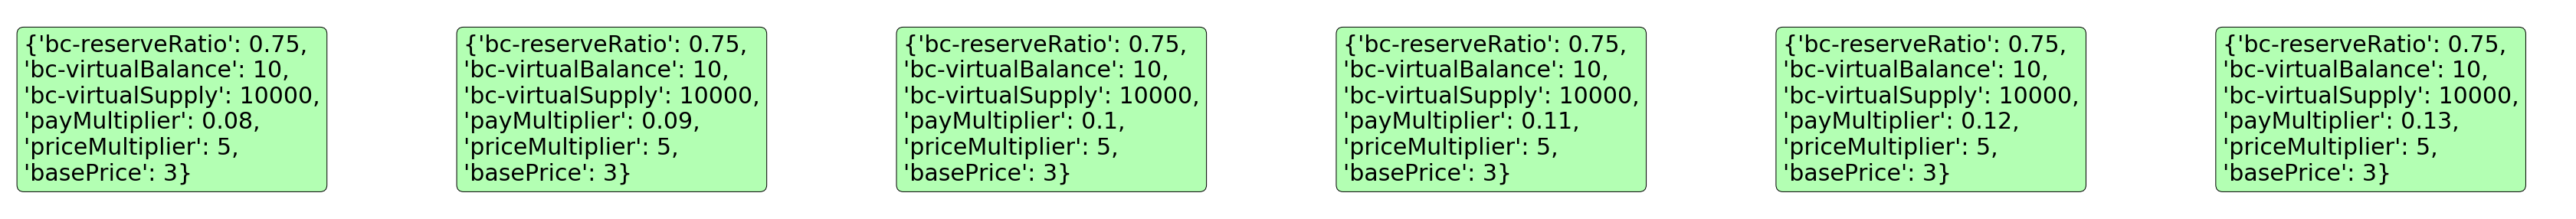

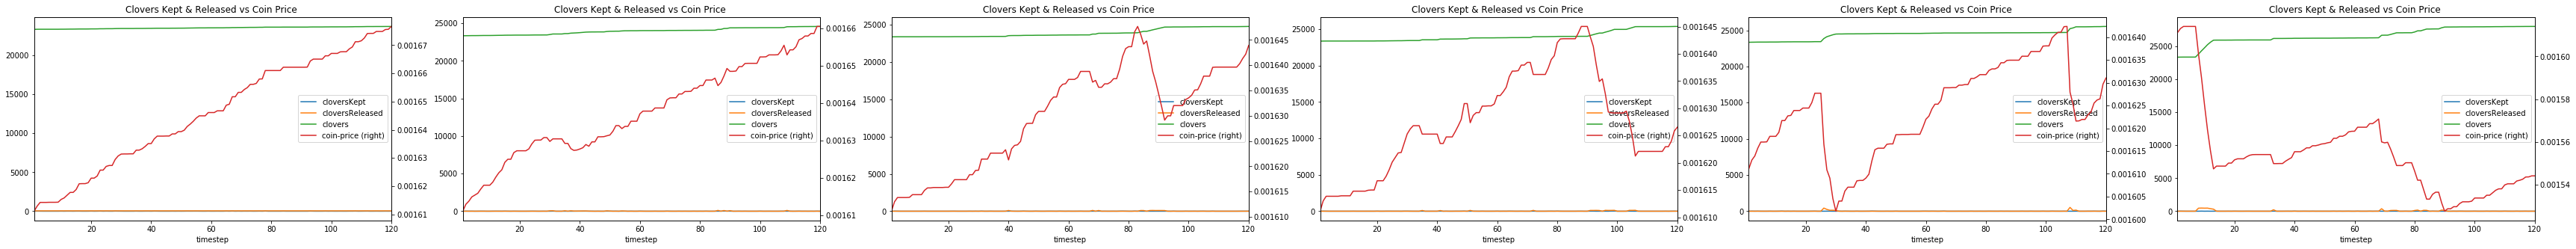

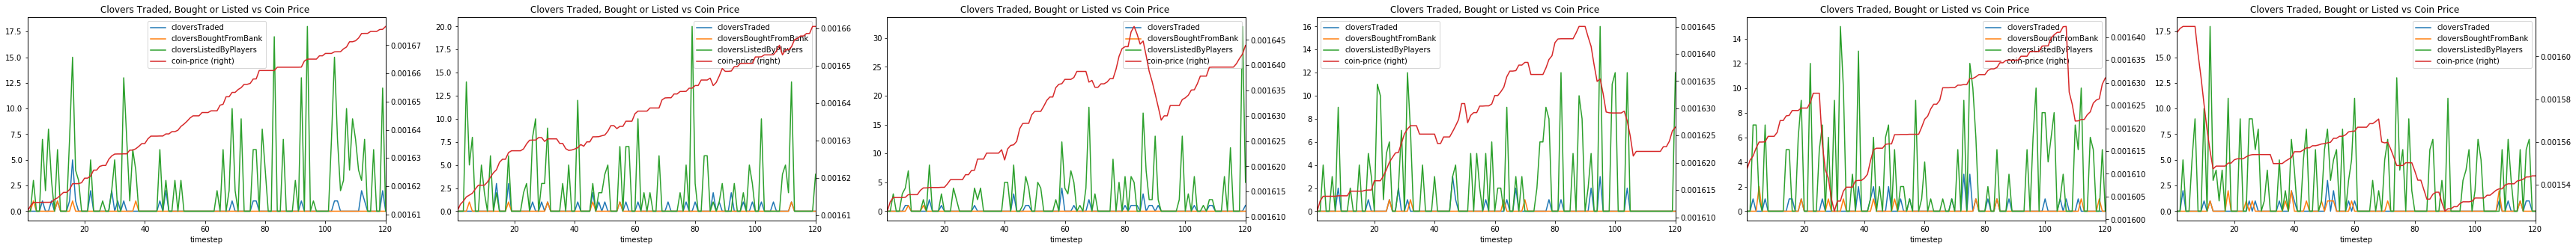

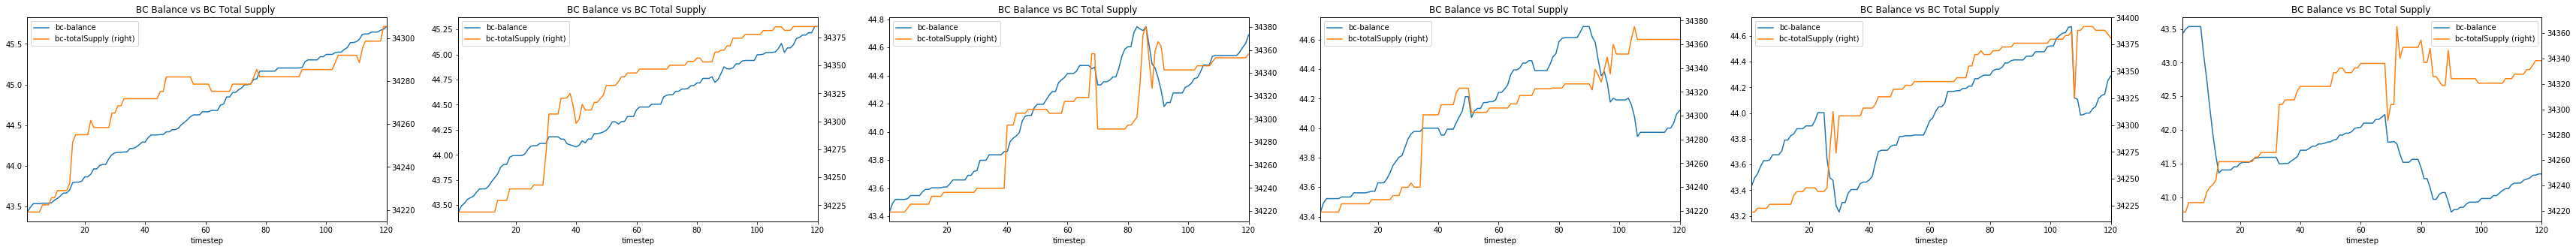

In [7]:
import graphing
importlib.reload(graphing)

graphing.make_title_bar(results, graphsize=(10,5))
graphing.make_graph(results, graphing.clovers_metrics_graph, graphsize=(10,5))
graphing.make_graph(results, graphing.clovers_traded_graph, graphsize=(10,5))
graphing.make_graph(results, graphing.bc_balance_graph, graphsize=(10,5))

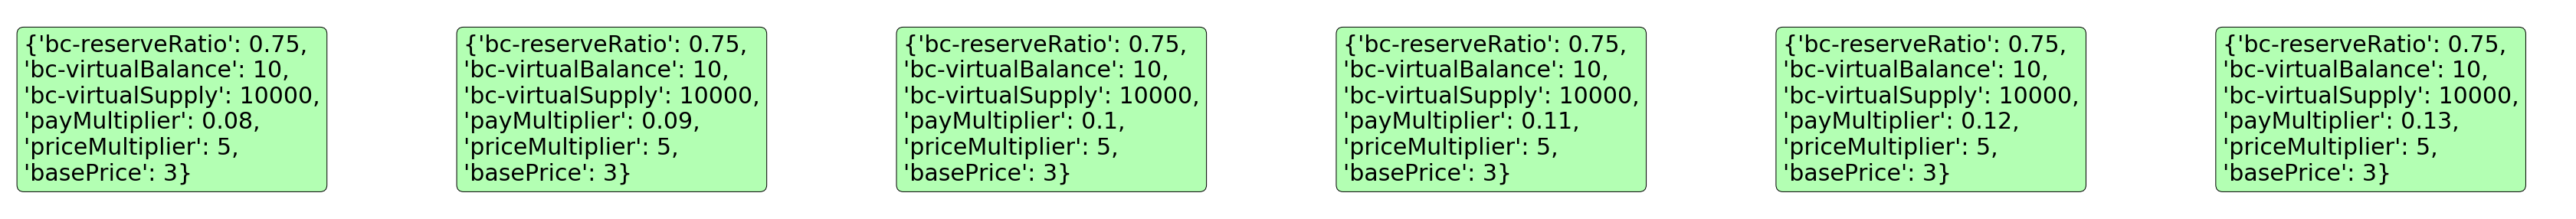

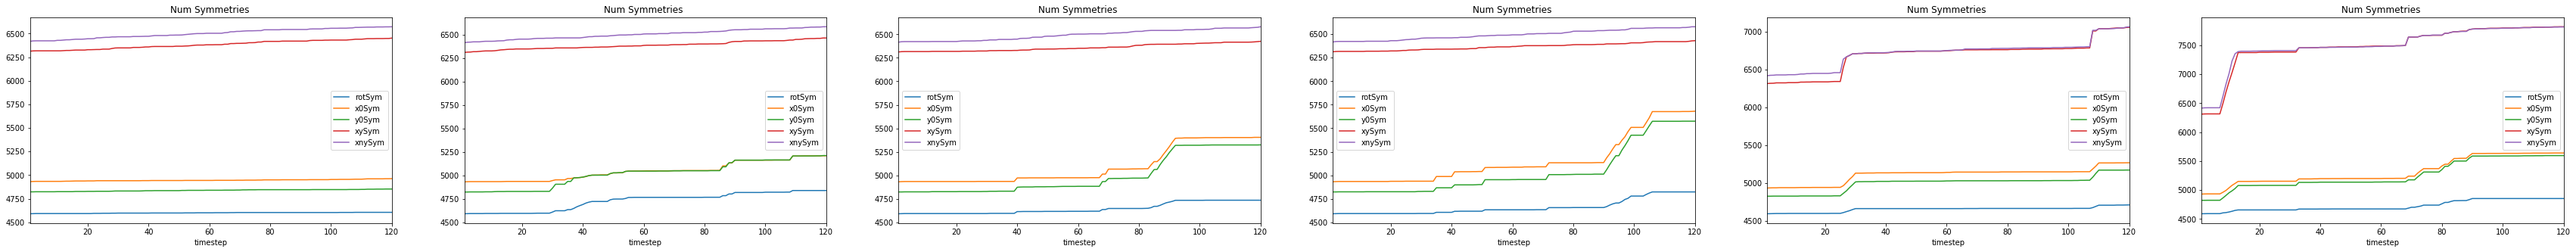

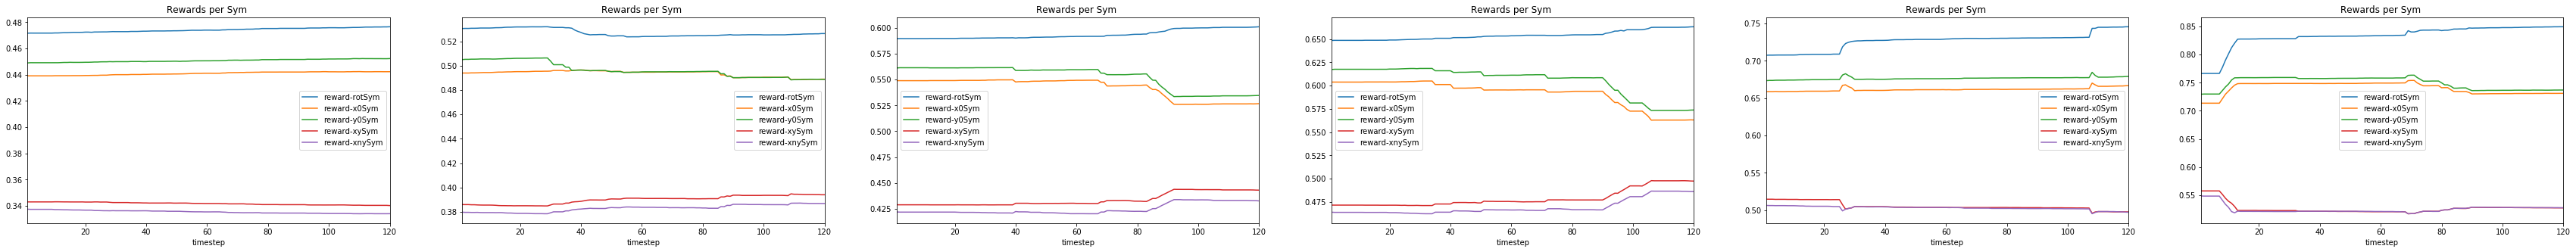

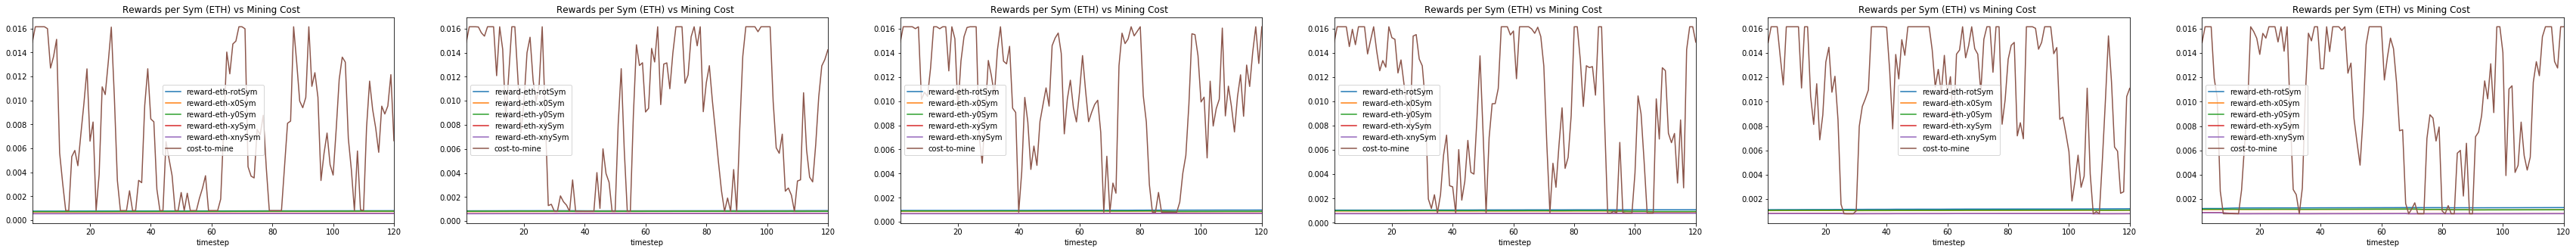

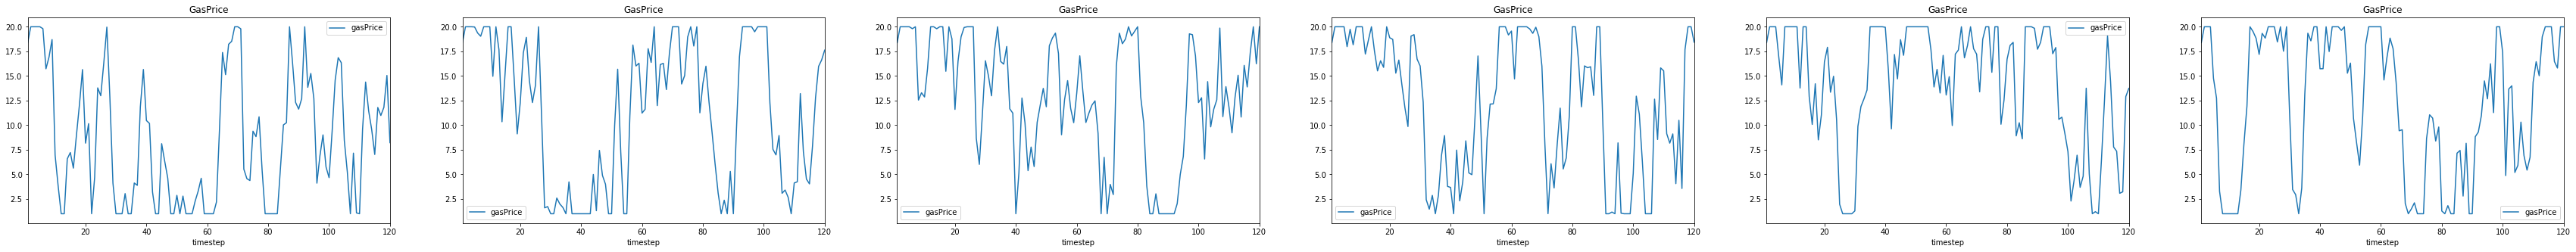

In [8]:
graphing.make_title_bar(results, graphsize=(10,5))
graphing.make_graph(results, graphing.num_syms_graph, graphsize=(10,5))
graphing.make_graph(results, graphing.rewards_per_sym_graph, graphsize=(10,5))
graphing.make_graph(results, graphing.rewards_per_sym_eth_graph, graphsize=(10,5))
graphing.make_graph(results, graphing.gas_price, graphsize=(10,5))

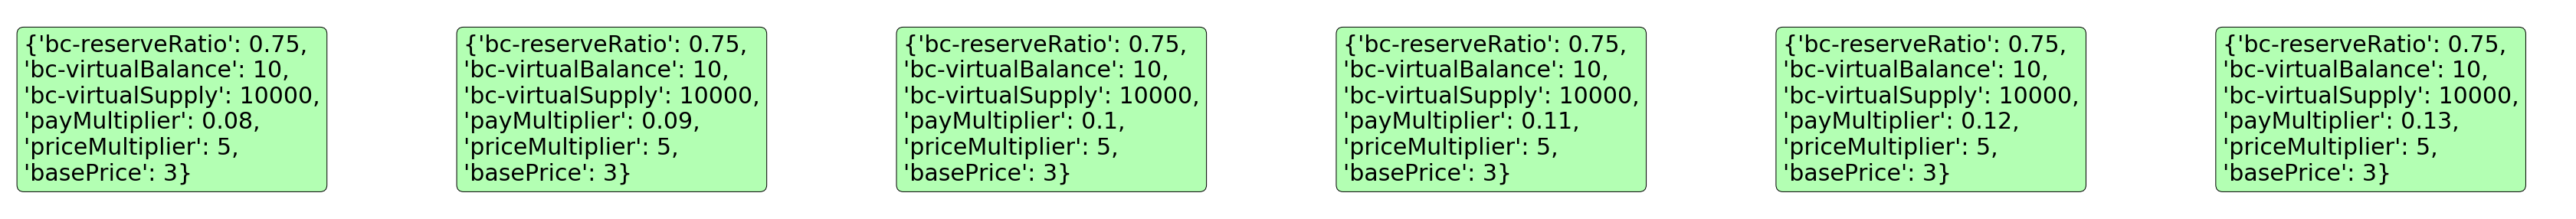

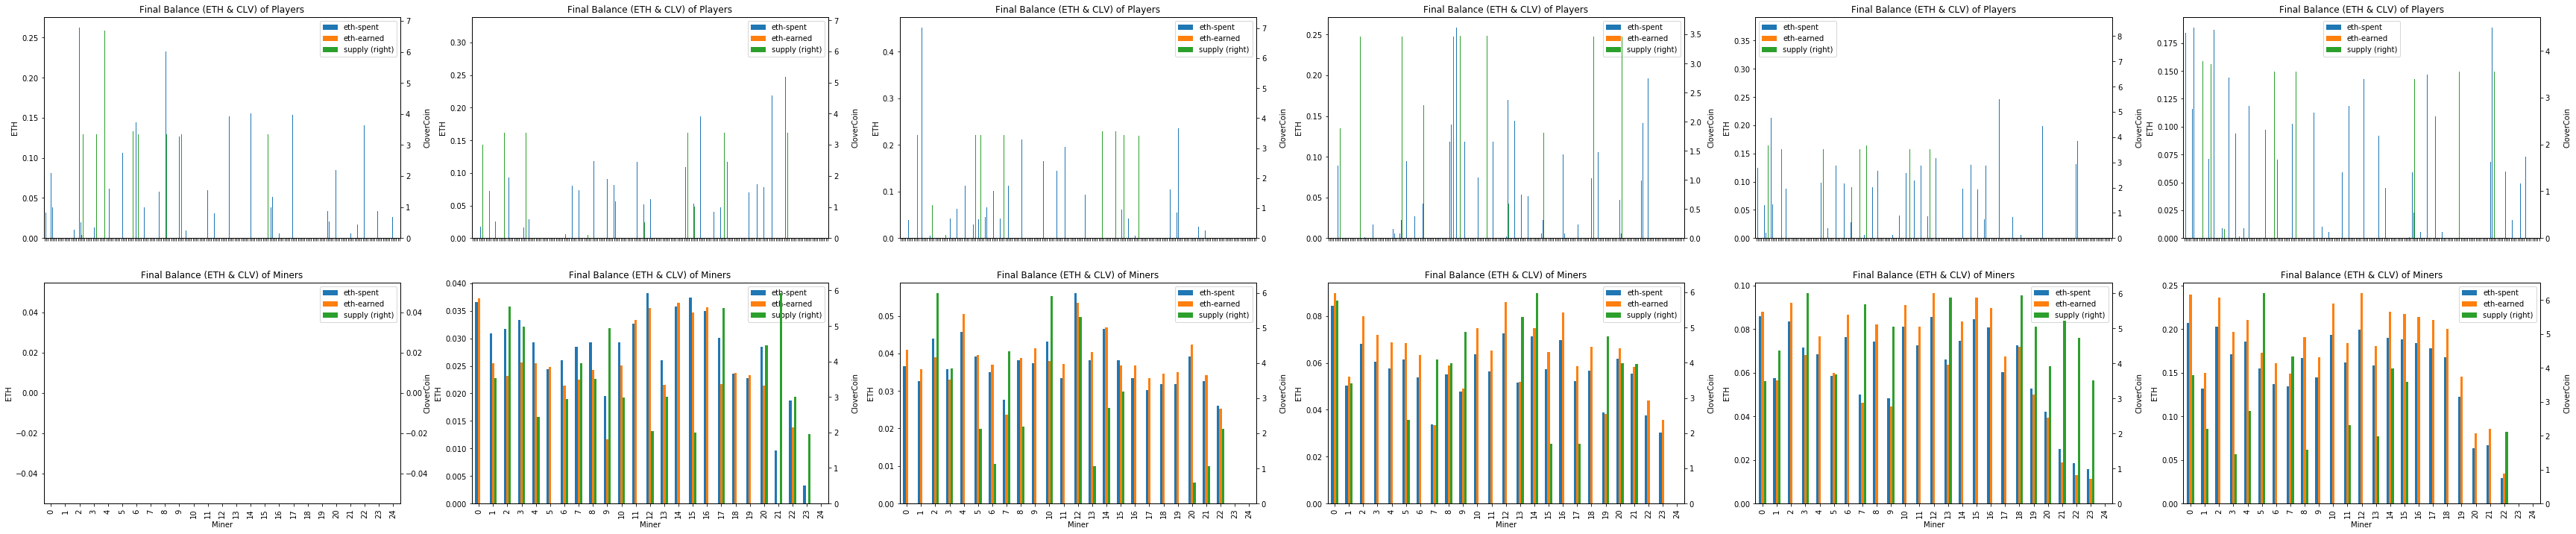

In [9]:
importlib.reload(graphing)
graphing.make_title_bar(results, graphsize=(10,5))
graphing.make_final_state_graph(results, graphsize=(10,6))

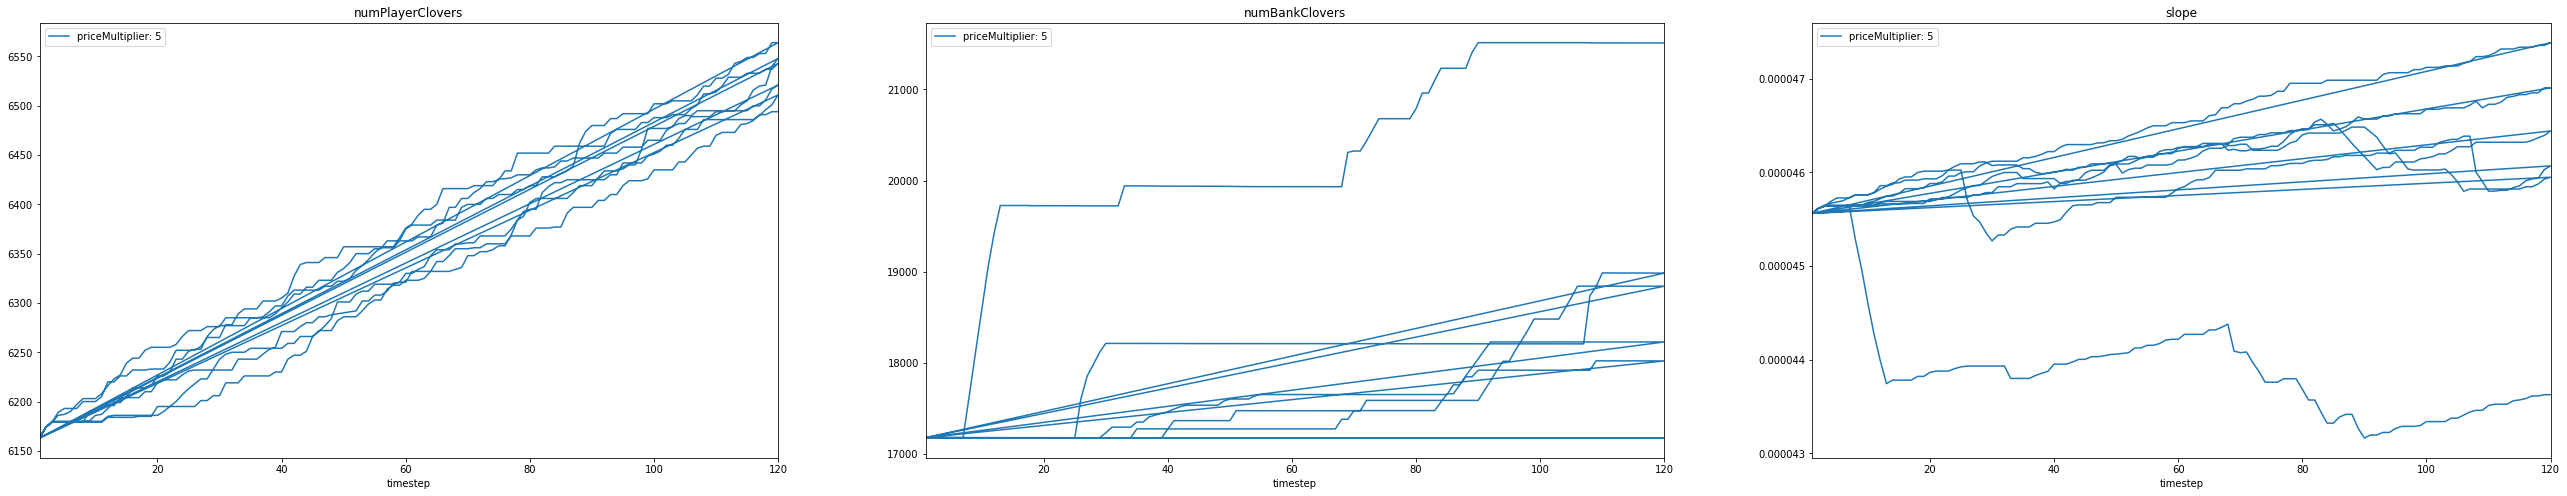

In [10]:
variableParams = ['priceMultiplier']

graphing.make_param_runs_graph(results, variableParams, ['numPlayerClovers','numBankClovers', 'slope'])

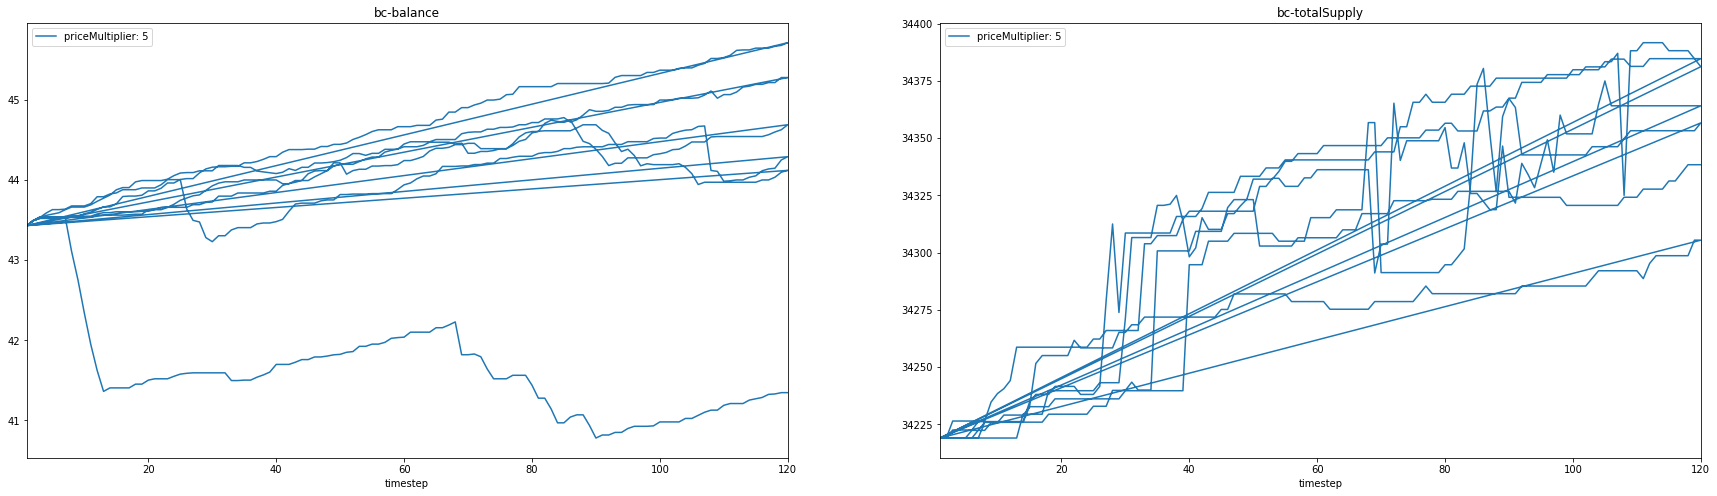

In [11]:
graphing.make_param_runs_graph(results, variableParams, ['bc-balance', 'bc-totalSupply'])